In [287]:
from tensorflow.keras.applications import ResNet50

In [288]:
ref_dir = './FID-300/references/'
dataset_dir = './FID-300/tracks_cropped/'


In [289]:
import PIL
import pathlib
import tensorflow as tf

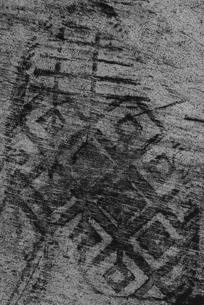

In [290]:
PIL.Image.open('./FID-300/tracks_cropped/00001.jpg')

In [291]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as k
import numpy as np
# Import RESNET50 without top (we need to extract features)
model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))


In [292]:
inputs = Input((224,224,3))
baseModel = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
for layer in baseModel.layers:
        layer.trainable = False

In [293]:
def create_model():
    inputs = Input((224,224,3))
    x = baseModel(inputs)
    x = tf.keras.layers.AveragePooling2D(pool_size=(7,7))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    model = Model(inputs, x)
    return model


In [294]:
# head = tf.keras.layers.Flatten()(model.output)
# head = tf.keras.layers.Dense(128, activation='relu')(head)

# # head = tf.keras.layers.MaxPooling2D(pool_size=2)(model.output)

# sister = tf.keras.models.Model(inputs=model.input, outputs=head)
# sister2 = tf.keras.models.Model(inputs=model.input, outputs=head)

In [295]:
feature_extractor = create_model()
imgA = Input(shape=(224,224,3))
imgB = Input(shape=(224,224,3))
featA = feature_extractor(imgA)
featB = feature_extractor(imgB)

In [296]:
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_squared, k.epsilon()))

distance = Lambda(euclidean_distance)([featA, featB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [297]:
from tensorflow.keras.optimizers.experimental import RMSprop
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

In [298]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_41 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_14 (Functional)          (None, 256)          24112256    ['input_40[0][0]',               
                                                                  'input_41[0][0]']        

In [299]:
#https://medium.com/wicds/face-recognition-using-siamese-networks-84d6f2e54ea4
#generate training pairs

print(dataset_dir)
print(ref_dir)

./FID-300/tracks_cropped/
./FID-300/references/


In [300]:
dataset_dir_p = pathlib.Path(dataset_dir)
dataset_cnt = len(list(dataset_dir_p.glob("*")))

ref_dir_p = pathlib.Path(ref_dir)
ref_cnt = len(list(ref_dir_p.glob("*")))

print(dataset_cnt, ref_cnt)

300 1175


In [301]:
import re
test = '00200.jpg'
test = re.sub(r'^0*', '', test)
test = re .sub(r'\.jpg', '', test)


def parse(s, ext):
    tmp = re.sub(r'^0*', '', s)
    tmp = re.sub(rf'\.{ext}', '', tmp)
    return tmp
parse('00210.jpg', 'jpg')

'210'

In [302]:

tmp_dataset = []
tmp_name = []
for elem in list(dataset_dir_p.glob("*")):
    tmp = tf.keras.utils.load_img(elem, target_size=(224,224))
    tmp = tf.keras.utils.img_to_array(tmp)
    tmp = tf.keras.applications.resnet50.preprocess_input(np.expand_dims(tmp, axis=0))
    test = elem.name
    test = parse(test, 'jpg')
    tmp_name.append(test)
    tmp_dataset.append(tmp)


In [303]:

ref_dataset = []
ref_name = []
for elem in list(ref_dir_p.glob("*")):
    tmp = tf.keras.utils.load_img(elem, target_size=(224,224))
    tmp = tf.keras.utils.img_to_array(tmp)
    tmp = tf.keras.applications.resnet50.preprocess_input(np.expand_dims(tmp, axis=0))
    test = elem.name
    test = parse(test, 'png')
    ref_name.append(test)
    ref_dataset.append(tmp)

In [304]:
import pandas as pd
df = pd.read_csv('./FID-300/label_table.csv', header=None)
df.columns = ['tmp_name', 'label']


In [305]:
tmp_label = []
for elem in tmp_name:
    label = df['label'][int(elem) - 1]
    tmp_label.append(label)

In [306]:
# tmp_dataset / tmp_label 
# tmp_dataset[idx] = ref_dataset[ref_name.index(f'{tmp_label[idx]}')]
# ref_dataset / ref_name 

ref_name = list(map(int, ref_name))

def generate_pair(tmp_dataset, tmp_label, ref_dataset, ref_name):
    label_dict = dict()
    for label in tmp_label:
        label_dict.setdefault(int(label), [index for index, curr_label in enumerate(ref_name) if int(label)==int(curr_label)])
    # print(label_dict)
    pair_img = []
    pair_label = []
    for idx, img in enumerate(tmp_dataset):
        pos_idx = label_dict.get(tmp_label[idx])
        # print(pos_idx)
        pos_img = ref_dataset[pos_idx[0]]
        pair_img.append((img, pos_img))
        pair_label.append(1)

        neg_idx = np.where(ref_name != tmp_label[idx])
        neg_img = ref_dataset[np.random.choice(neg_idx[0])]
        pair_img.append((img, neg_img))
        pair_label.append(0)
    return np.array(pair_img), np.array(pair_label)

img_pair, label_pair = generate_pair(tmp_dataset, tmp_label, ref_dataset, ref_name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


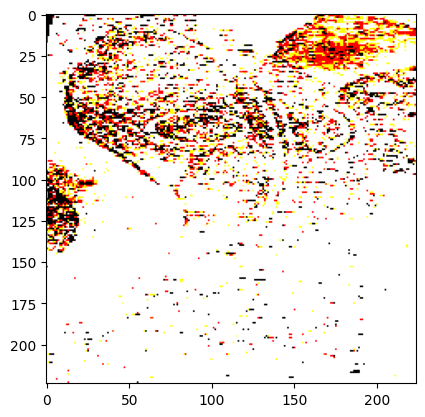

In [307]:
plt.imshow(img_pair[6,0,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


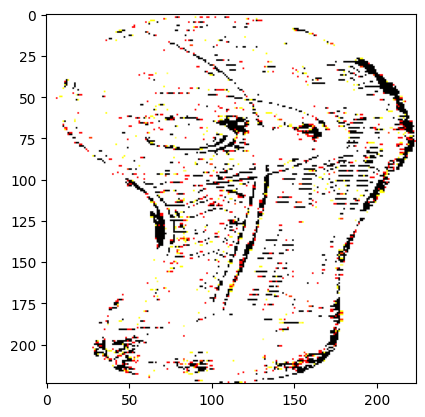

In [308]:

plt.imshow(img_pair[6,1,0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

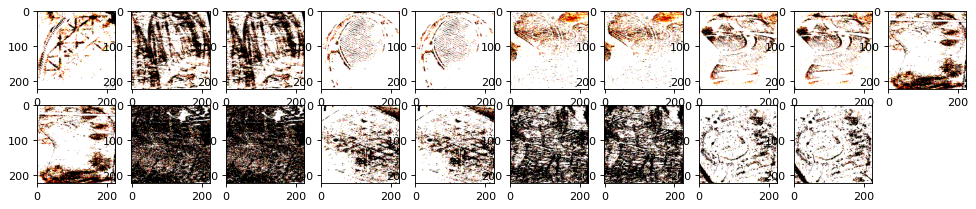

In [309]:
from matplotlib import pyplot as plt
# fig = plt.figure(figsize=(15,15), dpi=80)

# for i in range(1,10):
#     fig.add_subplot(10,10,i)
#     plt.imshow(img_pair[i,1,0])
# plt.show()
fig = plt.figure(figsize=(15,15), dpi=80)
for i in range(1,20):
    fig.add_subplot(10,10,i)
    plt.imshow(img_pair[i,0,0])

plt.show()


In [310]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_41 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_14 (Functional)          (None, 256)          24112256    ['input_40[0][0]',               
                                                                  'input_41[0][0]']        

In [311]:
history = model.fit([img_pair[:, 0,0], img_pair[:, 1,0]], label_pair[:], validation_split=0.1, batch_size=64, epochs=100)

Epoch 1/100
9/9 [==============================] - 7s 284ms/step - loss: 1.5490 - accuracy: 0.5278 - val_loss: 0.6942 - val_accuracy: 0.5667
Epoch 2/100
9/9 [==============================] - 1s 128ms/step - loss: 0.7257 - accuracy: 0.5907 - val_loss: 0.6418 - val_accuracy: 0.5333
Epoch 3/100
9/9 [==============================] - 1s 130ms/step - loss: 0.6495 - accuracy: 0.6537 - val_loss: 0.6521 - val_accuracy: 0.5500
Epoch 4/100
9/9 [==============================] - 1s 134ms/step - loss: 0.6168 - accuracy: 0.6741 - val_loss: 0.6173 - val_accuracy: 0.6833
Epoch 5/100
9/9 [==============================] - 1s 127ms/step - loss: 0.5881 - accuracy: 0.7259 - val_loss: 0.6075 - val_accuracy: 0.6833
Epoch 6/100
9/9 [==============================] - 1s 127ms/step - loss: 0.5735 - accuracy: 0.7241 - val_loss: 0.7310 - val_accuracy: 0.5500
Epoch 7/100
9/9 [==============================] - 1s 146ms/step - loss: 0.5835 - accuracy: 0.7444 - val_loss: 0.6977 - val_accuracy: 0.5500
Epoch 8/100
9

In [364]:
# mp = tf.keras.utils.load_img(elem, target_size=(224,224))
# tmp = tf.keras.utils.img_to_array(tmp)
# tmp = tf.keras.applications.resnet50.preprocess_input(np.expand_dims(tmp, axis=0))

tt_ref = tf.keras.utils.load_img("./tetsts.png", target_size=(224,224))
tt_ref = tf.keras.utils.img_to_array(tt_ref)
tt_ref = tf.keras.applications.resnet50.preprocess_input(np.expand_dims(tt_ref, axis=0))
tt_ref = np.array(tt_ref)

tt_base = tf.keras.utils.load_img("./base.png", target_size=(224,224))
tt_base = tf.keras.utils.img_to_array(tt_base)
tt_base = tf.keras.applications.resnet50.preprocess_input(np.expand_dims(tt_base, axis=0))
tt_base = np.array(tt_base)

In [365]:
img_pair[2, 0,0].shape

(224, 224, 3)

In [366]:
tt_base[0].shape

(224, 224, 3)

In [367]:
tt_ref[0].shape

(224, 224, 3)

In [368]:
model.predict([tt_base, tt_ref])

1/1 [==============================] - 0s 45ms/step


array([[0.06492881]], dtype=float32)

In [369]:
img_pair[6,0,0].shape

(224, 224, 3)

In [370]:
te = model.predict([tt_ref, img_pair[11,1]])
te[0][0] > 0

1/1 [==============================] - 0s 48ms/step


True

In [371]:
def predict(img):
    acc = 0
    idx = -1
    for i in range(0, 600):
        tmp = model.predict([img_pair[i,1], img])
        tmp = tmp[0][0]
        if tmp > acc:
            acc = tmp
            idx = i
    return idx, acc
idx,acc = predict(tt_ref)
print(idx, acc)

1/1 [==============================] - 0s 52ms/step
555 0.18667953


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


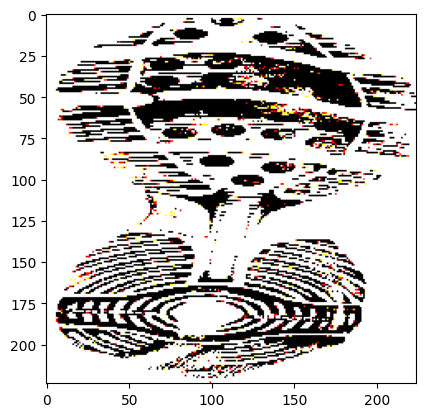

In [374]:
plt.imshow(img_pair[555,1,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


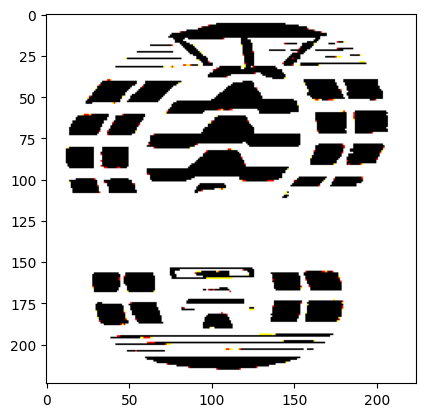

In [376]:
# well absolutely different but it was the closest one so...
plt.imshow(tt_ref[0])